In [28]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline

In [46]:
# general parameters

# qubit parameters
omega1 = 2*np.pi*5  # GHz
omega2 = 2*np.pi*5  # GHz
Delta = omega2 - omega1
omega_av = (omega1 + omega2) / 2
eta = 2*np.pi*0.3  # GHz

# drive parameters
Omega = 2*np.pi*0.2  # GHz
tlist = np.linspace(0, 100, 1000)  # ns



In [47]:

# operator definitions

I = qp.qeye(2)
sigmax = qp.sigmax()
sigmay = qp.sigmay()
sigmaz = qp.sigmaz()

I2 = qp.tensor([I, I])
sx1 = qp.tensor([sigmax, I])
sy1 = qp.tensor([sigmay, I])
sz1 = qp.tensor([sigmaz, I])
sx2 = qp.tensor([I, sigmax])
sy2 = qp.tensor([I, sigmay])
sz2 = qp.tensor([I, sigmaz])

# static part of interaction Hamiltonian
H01 = omega1 * (sz1 - I2)/ 2 + omega2 * (sz2 - I2)/ 2

# drive Hamiltonian
Hd1 = Omega * sx1 / 2
Hd2 = Omega * sx2 / 2

In [50]:
# pulse parameters
pi_factor1 = 0.5
pi_factor2 = 0.5

single_pulse_duration = 2*np.pi / Omega


def plot_phases(t_start1, t_start2, phi1, phi2, duration):
    args = {'t_start1': t_start1, 't_start2': t_start2, 'duration': duration, 'phi1': phi1, 'phi2': phi2}
    psi0 = qp.tensor([qp.basis(2, 0), qp.basis(2, 0)])

    t_final = 100

    def flat_pulse(t, t_start, duration):
        if t_start < t and t < t_start + duration:
            return 1
        else:
            return 0


    def q1_sigmax_drive(t, args):
        t_start = args['t_start1']
        duration = args['duration']
        return pi_factor1 * flat_pulse(t, t_start, duration) * np.cos((omega1) * t + args['phi1'])


    def q2_sigmax_drive(t, args):
        t_start = args['t_start2']
        duration = args['duration']
        return pi_factor2 * flat_pulse(t, t_start, duration) * np.cos(omega2 * t + args['phi2'])


    H = [H01,
        [Hd1, q1_sigmax_drive],
        [Hd2, q2_sigmax_drive],
        ]

    # integrate
    tvec = np.arange(0, t_final, 0.01)
    sol = qp.sesolve(H, psi0, tvec,
                    args=args,
                    # e_ops=[sx1, sy1, sz1, sx2, sy2, sz2],
                    options=qp.Options(max_step=1))
    
    # return sol

    slist = [[0,0], [0,1], [1,0], [1,1]]

    final_state = np.squeeze(sol.states[-1])
    for i, state in enumerate(final_state):
        plt.plot([0, np.real(state)], [0, np.imag(state)], 'o-', label=str(slist[i]))
    plt.axis('equal')
    plt.legend()

    plt.show()

    fig, ax = plt.subplots(3, 1, sharex='all', figsize=(14, 12))

    axn = ax[0]
    axn.plot(sol.times, [q1_sigmax_drive(t, args) for t in sol.times], label='q1 xy drive')
    axn.plot(sol.times, [q2_sigmax_drive(t, args) for t in sol.times], label='q2 xy drive')
    axn.legend()
    axn.set_title('xy drive pulses')
    axn.grid('all')

    axn = ax[1]
    slist = [[0,0], [0,1], [1,0], [1,1]]
    for i in range(4):
        axn.plot(sol.times, [np.squeeze(np.abs(s[i])**2) for s in sol.states],
                label=str(slist[i]),
                marker='o',
                markevery=slice(20*i, -1, 80),
                )
    axn.legend()
    axn.set_ylabel('abs sq.')
    axn.grid('all')
    axn.set_title('prob. amplitude abs squared')

    # phases
    axn = ax[2]
    # intrinsic phases
    for i in range(4):
        axn.plot(sol.times, [np.squeeze(np.angle(s[i]))/np.pi for s in sol.states],
                label=str(slist[i]),
                marker='o',
                markevery=slice(20*i, -1, 80),
                )

    #axn.set_yticks(np.arange(-1, 1.25, 0.25))
    axn.grid('all')
    axn.legend()
    axn.set_ylabel('angle/pi')
    axn.set_title('prob. amplitude phases')

    ax[-1].set_xlabel('time [nsec]')
    # ax[-1].set_xlim(0, 1)
    plt.show()
    return sol


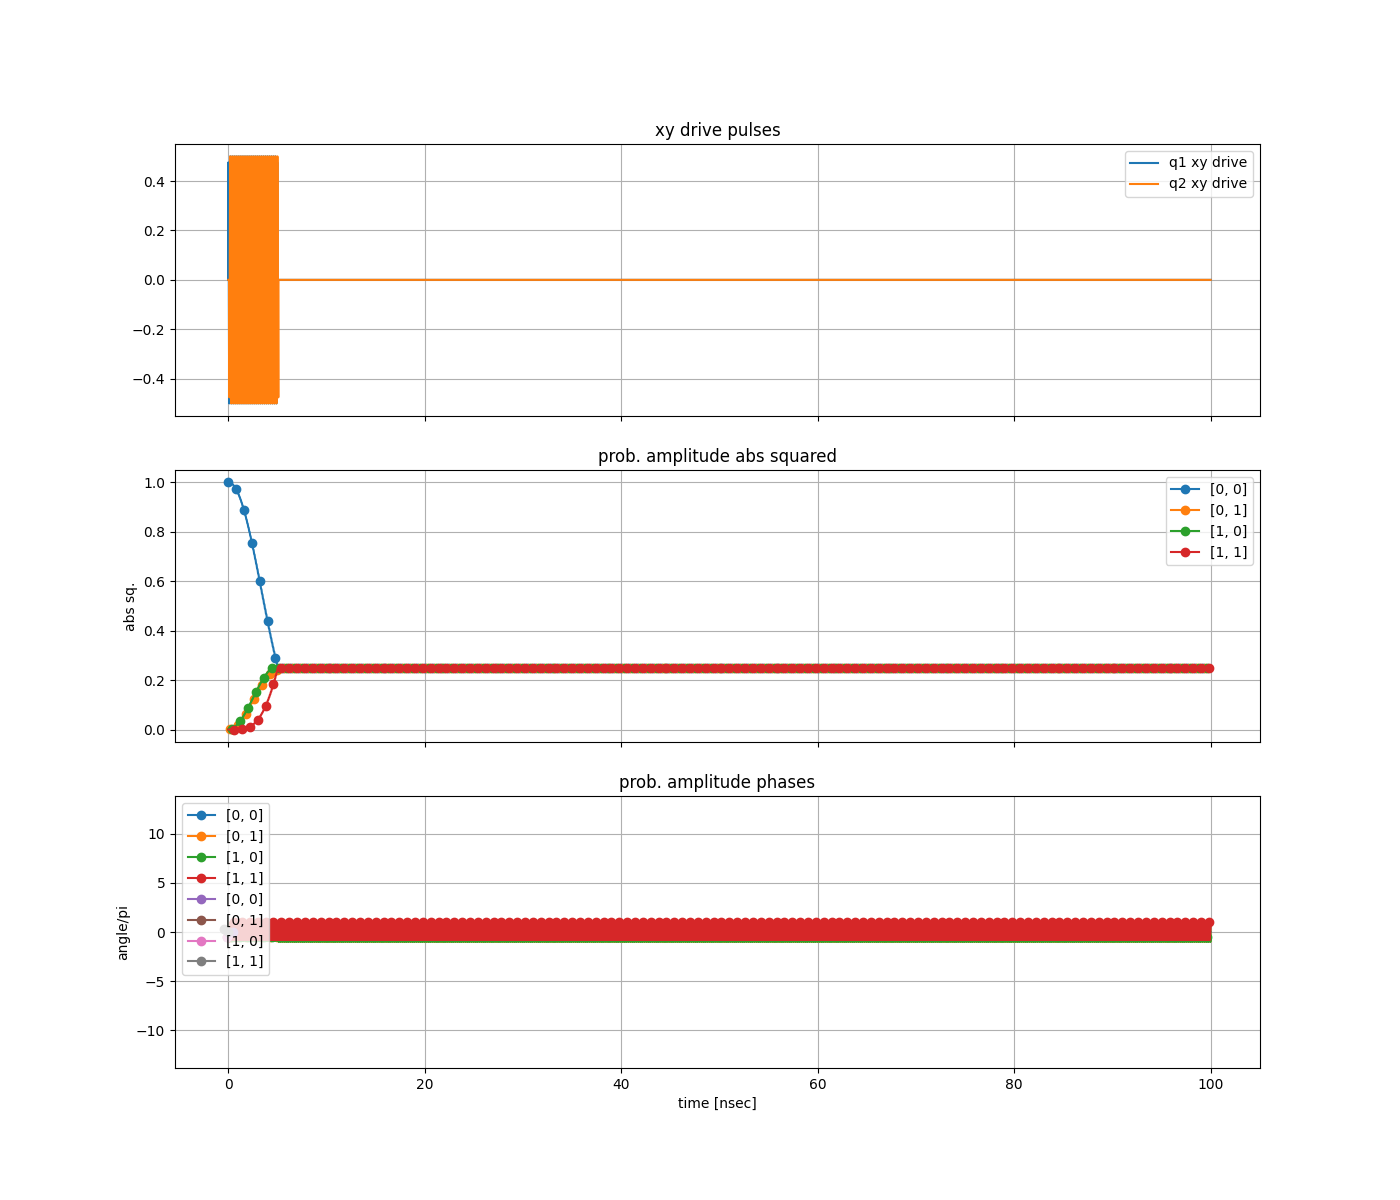

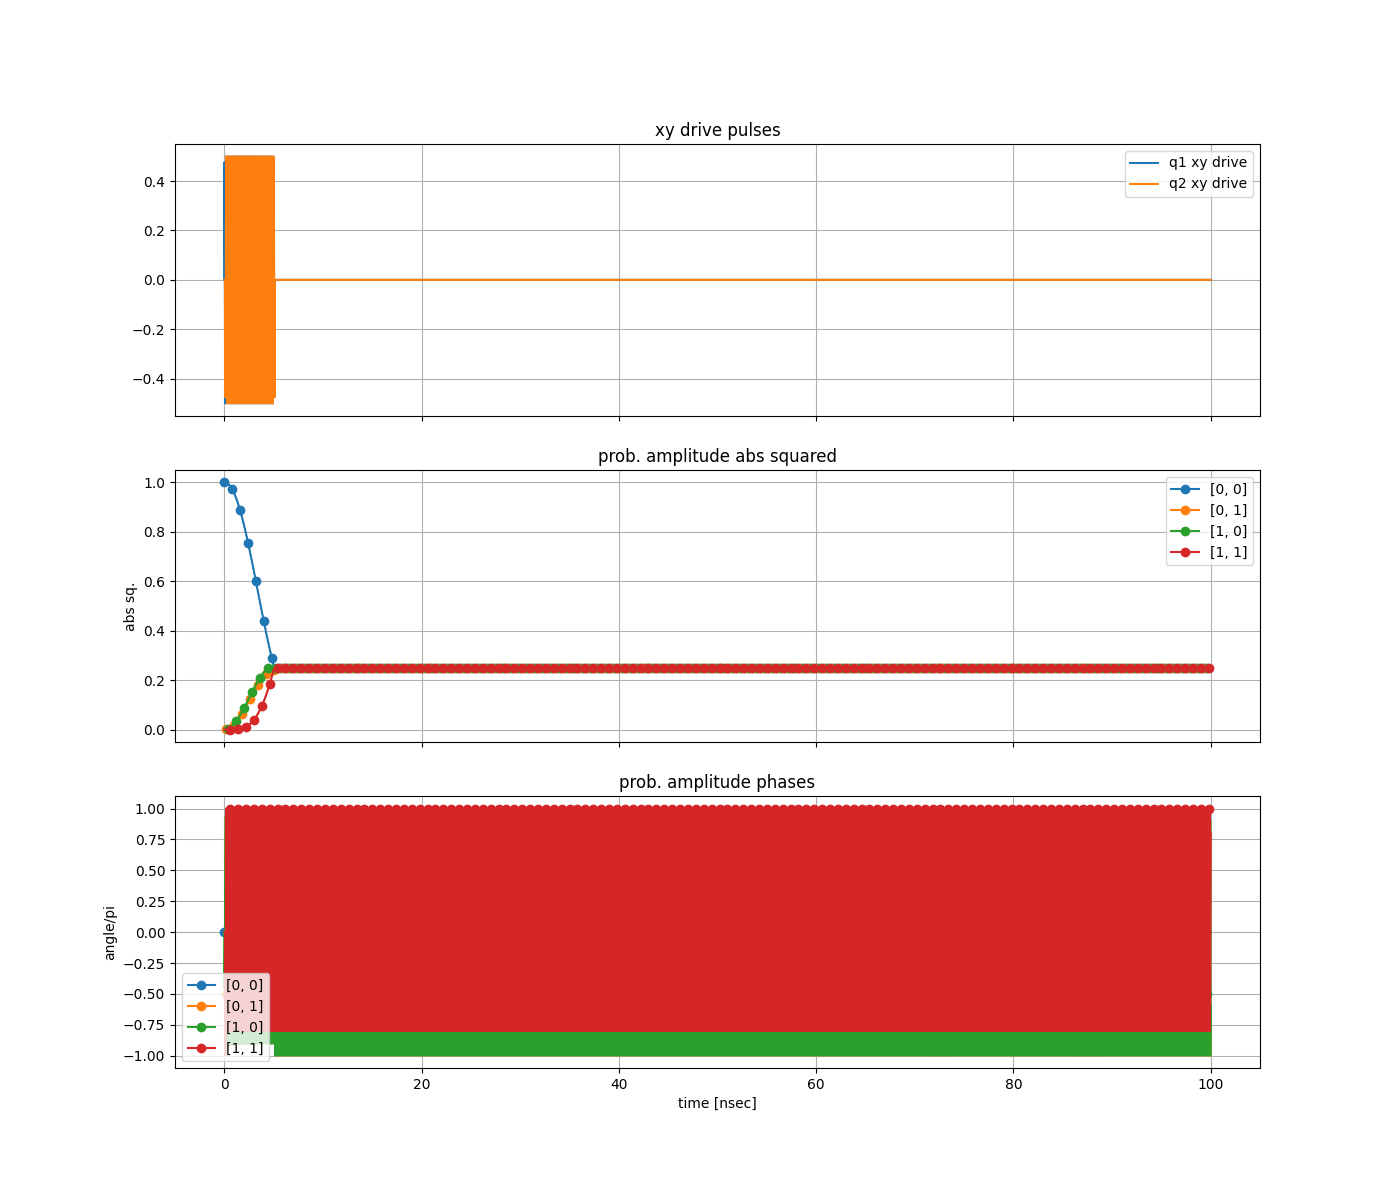

Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0

In [51]:

sol = plot_phases(t_start1=0.0, t_start2=0.1, phi1=0.0, phi2=0.0, duration=single_pulse_duration)
sol

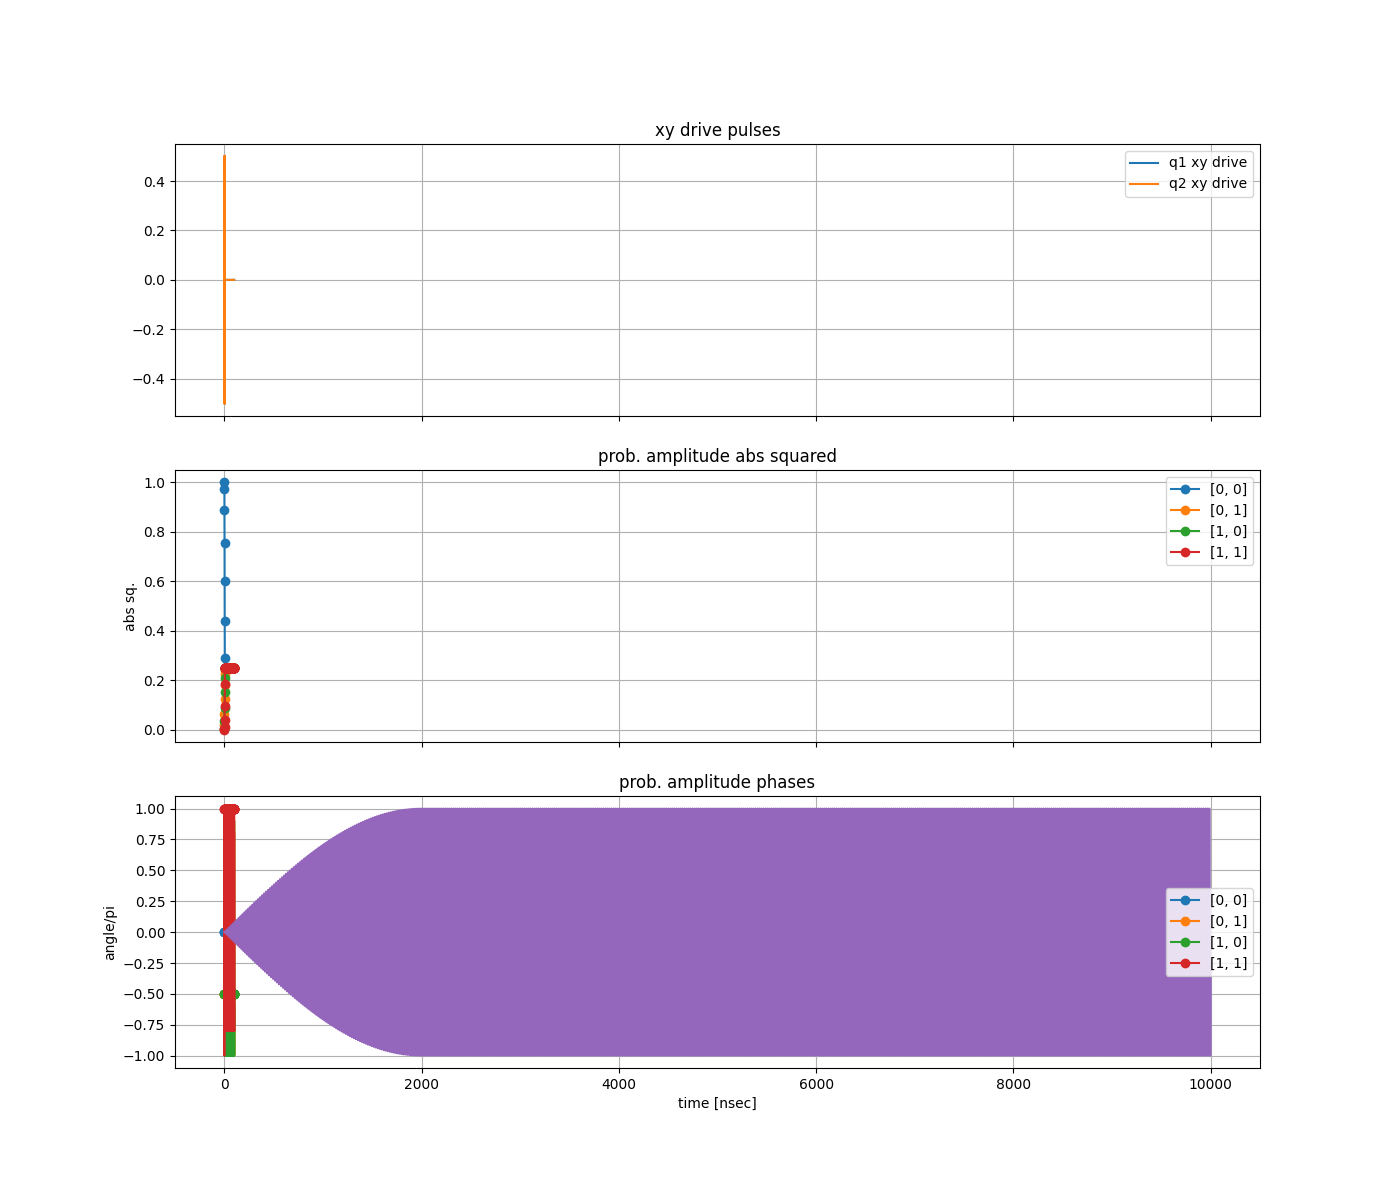

In [52]:
plt.plot(e_ops[0])
plt.show()

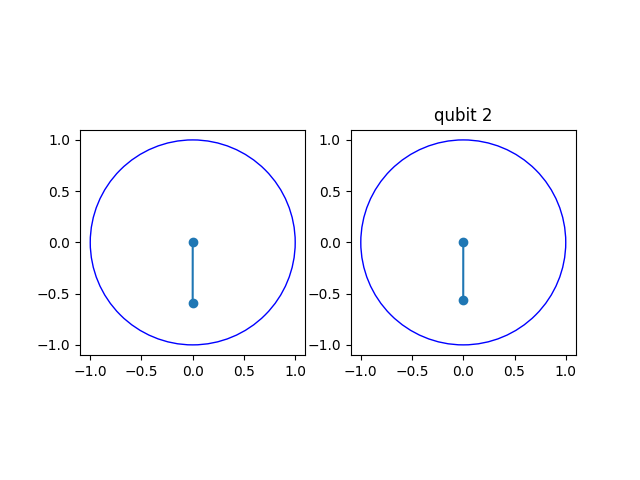

In [56]:
e_ops = qp.expect([sx1, sx2, sy1, sy2, sz1, sz2], sol.states)

frame = 200
fig, ax = plt.subplots(1, 2)#fig_kw={'num': 1, 'clear': True})
axn = ax[0]
sxy1_plt = axn.plot([0, e_ops[0][frame]], [0, e_ops[2][frame]], 'o-', label='X+iY')
axn.set_title('qubit 1')
axn.set_xlim(-1.1, 1.1)
axn.set_ylim(-1.1, 1.1)
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
axn.add_artist(circle)
axn.set_aspect(1)
axn = ax[1]
sxy2_plt = axn.plot([0, e_ops[1][frame]], [0, e_ops[3][frame]], 'o-', label='X+iY')
axn.set_title('qubit 2')
axn.set_xlim(-1.1, 1.1)
axn.set_ylim(-1.1, 1.1)
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
axn.add_artist(circle)
axn.set_aspect(1)


def update(frame):
    sxy1_plt[0].set_data([0, e_ops[0][frame]], [0, e_ops[2][frame]])
    sxy2_plt[0].set_data([0, e_ops[1][frame]], [0, e_ops[3][frame]])
    return sxy1_plt, sxy2_plt


from matplotlib import animation
anim = animation.FuncAnimation(fig, update, frames=range(len(e_ops[0])), interval=2, blit=True)
    

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, Button, HBox, VBox
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output


slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Velocity v:')
button = Button(description="Start")

# Global variables to store the figure, axis, and point
fig, ax = plt.subplots()
point, = plt.plot([], [], 'ro')

def plot_point(v):
    global fig, ax, point
    fig.clf()
    ax = fig.add_subplot(1, 1, 1)
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)

    # Initial point
    point, = ax.plot([], [], 'ro')
    
    # Setting the limits of x and y axis
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal', adjustable='box')

def start_animation(btn):
    global fig, ax, point

    v = slider.value

    # Animation update function
    def update(frame):
        t = frame / 100  # Scale the frame to slow down the animation
        x, y = np.cos(2 * np.pi * v * t), np.sin(2 * np.pi * v * t)
        point.set_data([x], [y])
        return point,

    ani = FuncAnimation(fig, update, frames=np.linspace(0, 100, 100), blit=True)
    display(fig)

button.on_click(start_animation)  # Link the button click to starting the animation

plot_point(slider.value)  # To display the initial plot
display(HBox([slider, button]))  # Arrange the slider and button horizontally


In [ ]:
%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, Button, HBox, VBox
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output

fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()